In [5]:
import pandas as pd
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from random import random
from io_utils import *

In [6]:
data_ob = load_RESSPECT_data()
object_ids = data_ob.get_all_object_ids()

In [7]:
color_band_dict = {'u':'C4','g':'C2', 'r':'C3', 'i':'C1', 'z':'k', 'Y':'C5'}

In [8]:
object_ids

6612.0
7860.0
3421.0
3368.0
3200.0
2478.0
1640.0
6509.0
2002.0
5537.0
8018.0


In [9]:
from LightCurve import LightCurve

In [10]:
number_of_days_in_lc = 100
time_step=2

In [11]:
def get_alert_mid_pt(event_df, bands, current_date=None):
    
    if current_date is not None:
        date_difference = event_df[data_ob.time_col_name] - current_date
        past_index = (date_difference>=-50) & (date_difference<=0)
        event_df = event_df[past_index]
    
    band_mid_points = []
    for i,band in enumerate(bands):
        band_index = event_df[data_ob.band_col_name] == band
        band_df = event_df[band_index]
        
        PCs = np.load("PCs.npy")
        PCs = PCs[0:3]
        initial_guess = [.93,.03 ,.025]
        #regularization_base = [.93,.04,.012]
        if(len(band_df)>0):
            max_index = np.argmax(band_df[data_ob.flux_col_name])
            band_mid_points.append(band_df[data_ob.time_col_name][max_index])
    if len(band_mid_points)>0:
        return np.median(np.array(band_mid_points))
    else:
        return None

In [12]:
def gen_all_band_same_maxpt_PCs():

    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))

    for i,object_id in enumerate(object_ids):
        event_df = data_ob.get_data_of_event(object_id)
        mid_point = get_alert_mid_pt(event_df, data_ob.band_map.keys())
        print(mid_point)
        if mid_point is not None:

            start_date = mid_point-number_of_days_in_lc/2
            end_date = mid_point+number_of_days_in_lc/2

            start_index = event_df['MJD']>= start_date
            end_index = event_df['MJD'] <= end_date

            df_within_date = event_df[start_index*end_index]

            for band in data_ob.band_map.keys():

                band_df = df_within_date[df_within_date[data_ob.band_col_name] == band]

                if len(band_df)>0:

                    rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue



                    max_loc = int((mid_point-np.amin(band_df['MJD']))/2)
                    flux_data = np.zeros((51))
                    flux_data[25-max_loc:25-max_loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
        else: 
            continue

        
        
        
        

In [50]:
def gen_all_band_diff_maxpt_PCs():
    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))

    for i,object_id in enumerate(object_ids):
        
        event_df = data_ob.get_data_of_event(object_id)
    
        for band in data_ob.band_map.keys():
            
            band_index = event_df[data_ob.band_col_name]==band
            band_df = event_df[band_index]
            
            if(len(band_df)>0):
                loc = np.argmax(band_df[data_ob.flux_col_name])
                mid_point = band_df[data_ob.time_col_name][loc]
                start_date = mid_point-number_of_days_in_lc/2
                end_date = mid_point+number_of_days_in_lc/2
                start_index = band_df['MJD']>= start_date
                end_index = band_df['MJD'] <= end_date


                band_df = band_df[start_index*end_index]
                if len(band_df)>0:
                    loc = np.argmax(band_df[data_ob.flux_col_name])
                    #rand_int = int(random()*5)-2
                    rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue

                    flux_data = np.zeros((51))
                    flux_data[25-loc:25-loc+len(band_df['MJD'])] = band_df['FLUXCAL']
                    final_array[band][i] = flux_data
                    
                    
    return final_array

In [51]:
final_array = gen_all_band_diff_maxpt_PCs()
print(final_array.keys())

dict_keys(['r', 'Y', 'u', 'i', 'z', 'g'])


In [52]:
from sklearn.decomposition import PCA

In [53]:
color_band_dict['u']

'C4'

In [54]:
PC_dict = {}

for pb_name in data_ob.band_map.keys():
    pca = PCA(n_components=10)
    pca.fit(final_array[pb_name])
    PC_dict[pb_name] = pca.components_
    print(PC_dict[pb_name].shape)

(10, 51)
(10, 51)
(10, 51)
(10, 51)
(10, 51)
(10, 51)


In [55]:
print(PC_dict.keys())

dict_keys(['r', 'Y', 'u', 'i', 'z', 'g'])


In [56]:
data_ob.band_map.keys()

dict_keys(['r', 'Y', 'u', 'i', 'z', 'g'])

r


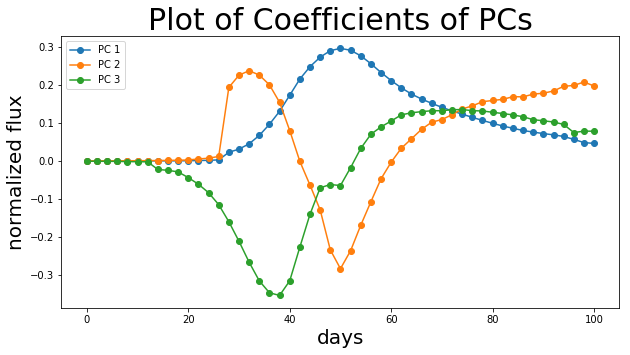

Y


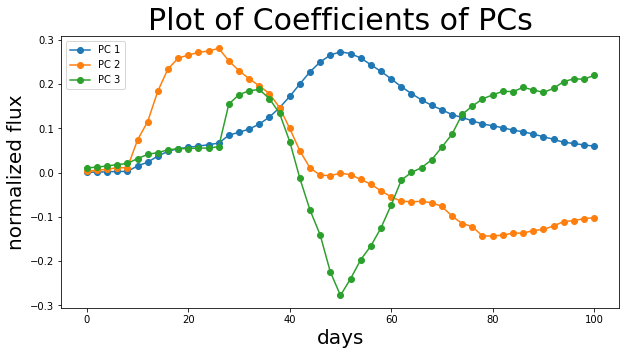

u


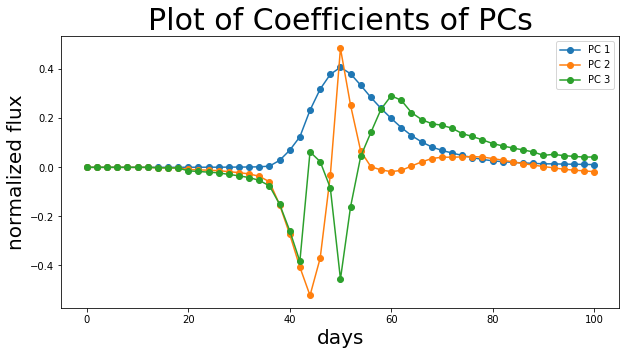

i


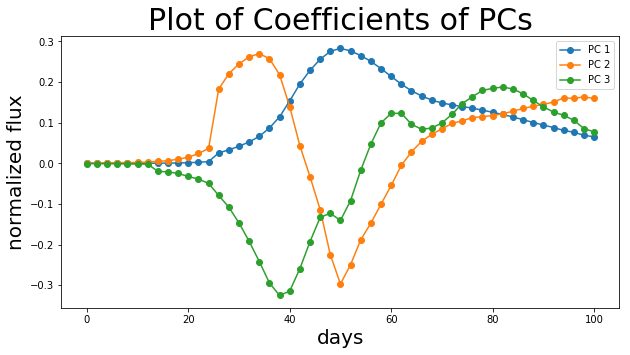

z


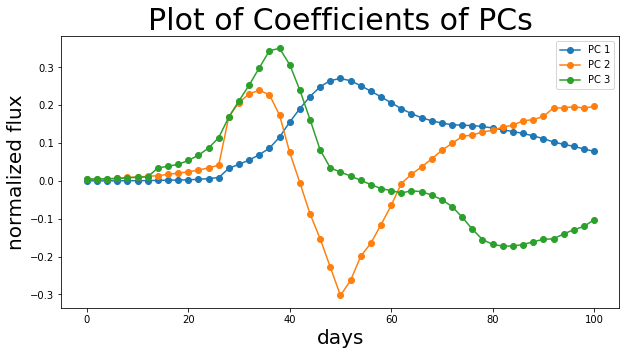

g


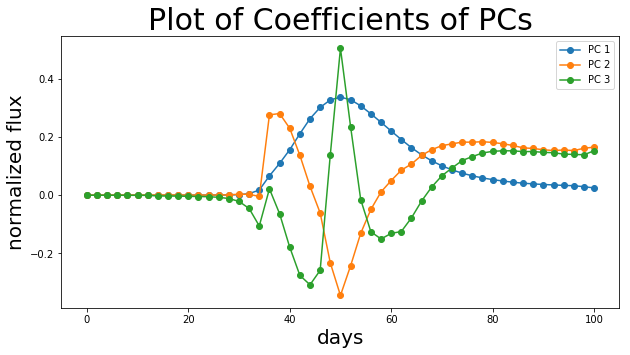

In [57]:
for band in data_ob.band_map.keys():
    print(band)
    PCs= PC_dict[band]
    fig = plt.figure(figsize=(10,5))
    for i in range(3):
        PC = PCs[i]
        x = np.arange(0,102,2)
        plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

    plt.xlabel("days", fontsize = 20)
    plt.ylabel("normalized flux", fontsize=20)

    plt.legend()
    plt.title("Plot of Coefficients of PCs",fontsize=30)
    #fig.savefig("Plot of PCs")
    plt.show()

In [58]:
np.save("principal_components/PC_all_bands_diff_mid_pt_dict", PC_dict)

In [20]:
print(PC_dict['u'][0:3])

[[-1.23560508e-05 -1.63544567e-05 -2.02266965e-05 -7.15816880e-05
  -4.02965132e-04 -3.15905415e-04 -2.15996760e-04 -3.44605297e-04
  -2.88269275e-04 -4.31534330e-04  5.83794995e-05  2.85206254e-04
   4.72312382e-04  1.15548347e-03  3.17272982e-02  3.83748978e-02
   4.09514229e-02  4.49424614e-02  5.25469838e-02  8.61549663e-02
   1.40910735e-01  2.21811958e-01  3.13694873e-01  3.73375514e-01
   3.90188473e-01  3.77413902e-01  3.41282709e-01  2.94140054e-01
   2.45447372e-01  2.00906076e-01  1.63954139e-01  1.32678047e-01
   1.06714354e-01  8.52597580e-02  6.83783333e-02  5.65091967e-02
   4.75558104e-02  3.82990427e-02  3.07412374e-02  2.48390361e-02
   2.10670389e-02  1.84574560e-02  1.65636970e-02  1.48234618e-02
   1.34654178e-02  1.24259530e-02  1.16615060e-02  1.11832892e-02
   1.09245777e-02  9.77613415e-03  9.39121903e-03]
 [ 3.80580964e-05  3.98762496e-05  1.80618677e-03  2.35033204e-03
   2.25685436e-03  2.58972022e-03  3.00581090e-03  3.18344164e-03
   3.65245140e-03  4.4424

In [ ]:
for object_id in object_ids:
    event_df = data_ob.get_data_of_event(object_id)
    lc = LightCurve(data_ob.get_data_of_event(object_id), time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    fig = lc.plot_light_curve(color_band_dict, alpha = 1)
    plt.show()
    plt.close('all')
    
    

In [ ]:
num_of_elements=51
final_array = np.zeros((len(object_ids),num_of_elements))

for j in range(10):
    
    for i,object_id in enumerate(objects_ids):
        #print(i)
        ob_list = []
        object_mask = df['SNID']==object_id
        object_df = df[object_mask]


        #for band in filters.keys():

        band_mask = object_df['FLT'] == 'r'
        band_df = object_df[band_mask]

        index_of_maximum = np.argmax(band_df['FLUXCAL'])
        date_of_maximum = band_df['MJD'][index_of_maximum]
        #print(date_of_maximum)

        start_date = date_of_maximum-50
        end_date = date_of_maximum+50 

        start_index = band_df['MJD']>= start_date
        end_index = band_df['MJD'] <= end_date

        df_within_date = band_df[start_index*end_index]
        #print(df_within_date['MJD'])
        max_loc = np.argmax(df_within_date['FLUXCAL'])
        max_flux = df_within_date['FLUXCAL'][max_loc]
        rand_int = int(random()*5)+4
        #rand_int = 7
        #rand_int = 0
        shifted_flux = np.zeros_like(df_within_date['FLUXCAL'])
        len_flux = len(df_within_date['FLUXCAL'])
        if (rand_int>0)&(len_flux>rand_int):
            shifted_flux[rand_int:len_flux] = df_within_date['FLUXCAL'][0:len_flux-rand_int]
            
            
        elif (rand_int<0)&(rand_int>-len_flux-1):
            shifted_flux[0:len_flux+rand_int] = df_within_date['FLUXCAL'][-rand_int:len_flux]

            
        elif (rand_int==0):
            shifted_flux = df_within_date['FLUXCAL']
        
        else:
            continue

        #print(max_loc)
        flux_data = np.zeros((num_of_elements))
        flux_data[25-max_loc:25-max_loc+len(df_within_date['MJD'])] = shifted_flux
        final_array[i] = flux_data
        print(np.argmax(flux_data))
        
        x = np.arange(51)-26
        #plt.plot(x,flux_data)
        #plt.show()
        #plt.close()
        



In [ ]:
x = np.arange(51)-26
plt.xlabel("time")
plt.ylabel("Normalized flux")
plt.plot(x,final_array[1]/np.amax(final_array[1]))
print(final_array[1])

In [ ]:
print(len(objects_ids))

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(final_array)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.singular_values_

In [ ]:
PCs = pca.components_

In [5]:
PCs = np.load("PCs.npy")
PCs = PCs[0:3]

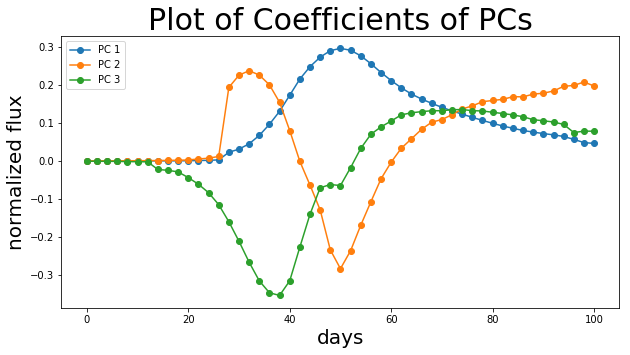

In [6]:
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("normalized flux", fontsize=20)
    
plt.legend()
plt.title("Plot of Coefficients of PCs",fontsize=30)
fig.savefig("Plot of PCs")
plt.show()

In [ ]:
np.save("principal_components/PCs_shifted",pca.components_)